# Convolutional Neural Networks

Here's the standard structure of a PyTorch CNN:

The first thing to notice is the use of `nn.Sequential()`. This allows us to create chains of layers. When we use one of these chains in `forward()`, the input goes through each element in the array of layers in succession. You can use this to break your model into more logical arrangements. 

In this network, we have two chains:  

        The `features` block

        the `classifier`

Let's take a look at the new layers we're introducing, starting with `Conv2d`.

## Convolutions
`nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)`

The `in_channels` is the number of input channels we'll be receiving in the layer, in the beginning of the network, we're taking the RGB image as input, so the number of input channels is 3. 

`out_channels`, is the number of output channels, which corresponds to the number of filters in our conv layer. 

Next is `kernel_size`, shich desscribes the height and width of our filter. This can be a single scalar describing a square. 

`stride` indicates how many steps across the input we move when adjusting the filter to a new position. In our example, the stride is 2, which has the effect of making a feature map that ishalf the size of the input.  

We can also pass in a tuple $(a,b)$ that would allow us to move $a$ across and $b$ down on each step. 

`padding` allows us to complete the convolution, so that we when we get to the edge the values are covvered by the filters. If you don't set padding, any edge case that PyTorch encounters will simply be thrown away. 

## Pooling
Pooling layers reduce the resolution of the network from the previous input layer, which gives us fewer parameters in lower layers. This compression results in faster computation and helps prevent overfitting in the network. In our model we're using `MaxPool2d` with a kernel size of 3. 

## Dropout 
by default, the `Dropout` layers in the example CNN network are initialized with 0.5 meaning that 50% of the input tensor is randomly zeroed out.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

# Configuration class
class Config:
    """Centralized configuration for the training pipeline."""
    # Data paths
    train_path = './train'
    val_path = './val'
    test_path = './test'
    
    # Model hyperparameters
    input_size = 12288  # 64 * 64 * 3
    hidden1 = 84
    hidden2 = 50
    num_classes = 2
    
    # Training hyperparameters
    batch_size = 64
    learning_rate = 0.001
    epochs = 20
    device = 'mps' if torch.backends.mps.is_available() else 'cpu'
    
    # Data loader settings
    num_workers = 0  # Safe for notebooks
    pin_memory = False
    
    # Model checkpoint
    checkpoint_dir = Path('./checkpoints')
    checkpoint_dir.mkdir(exist_ok=True)
    model_save_path = checkpoint_dir / 'simplenet_best.pth'

config = Config()
print(f"Using device: {config.device}")

Using device: mps


In [16]:
# Data loading function
def get_dataloaders(config):
    """Create train, validation, and test dataloaders."""
    
    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])
    
    # Create datasets
    train_dataset = datasets.ImageFolder(root=config.train_path, transform=transform)
    val_dataset = datasets.ImageFolder(root=config.val_path, transform=transform)
    test_dataset = datasets.ImageFolder(root=config.test_path, transform=transform)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.batch_size,
        shuffle=True,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=config.batch_size,
        shuffle=False,
        num_workers=config.num_workers,
        pin_memory=config.pin_memory
    )
    
    print(f"Train samples: {len(train_dataset)}")
    print(f"Val samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Class names: {train_dataset.classes}")
    
    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_dataloaders(config)

Train samples: 1023
Val samples: 150
Test samples: 209
Class names: ['cat', 'fish']


In [17]:
from torch import nn


class CNNNet(nn.Module):

    def __init__(self, num_classes=2):
        super().__init__()  # Modern Python 3+ syntax
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # ✅ Fixed: use function instead of creating new layer
        x = self.classifier(x)
        return x
    

model = CNNNet(num_classes=config.num_classes).to(config.device)
print(f"Model: {model}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Model: CNNNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)


## Using Pretrained Models in PyTorch
Pytorch provides many of the most popular models by default in the `torchvision` library. For Alexnet, all you need to do is this:

In [18]:
import torchvision.models as models

alexnet = models.alexnet(num_classes=2)
resnet = models.resnet18(num_classes=2)
print(alexnet)
print("\n",resnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [19]:
# Training and evaluation functions with history tracking
class Trainer:
    """Handles model training and evaluation with history tracking."""
    
    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.device = config.device
        
        # Loss and optimizer
        self.criterion = nn.CrossEntropyLoss().to(self.device)
        self.optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
        
        # Learning rate scheduler (reduce on plateau)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5, patience=3
        )
        
        # History tracking
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'val_acc': [],
            'lr': []
        }
        
        # Best model tracking
        self.best_val_acc = 0.0
    
    def train_epoch(self, train_loader):
        """Train for one epoch."""
        self.model.train()
        running_loss = 0.0
        
        train_pbar = tqdm(train_loader, desc='Training')
        for inputs, targets in train_pbar:
            inputs = inputs.to(self.device)
            targets = targets.to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, targets)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            train_pbar.set_postfix({'loss': loss.item()})
        
        return running_loss / len(train_loader)
    
    def validate(self, val_loader):
        """Validate the model."""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc='Validating')
            for inputs, targets in val_pbar:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                
                running_loss += loss.item()
                
                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
                val_pbar.set_postfix({'loss': loss.item(), 'acc': correct/total})
        
        val_loss = running_loss / len(val_loader)
        val_acc = correct / total
        
        return val_loss, val_acc
    
    def fit(self, train_loader, val_loader, epochs):
        """Train the model for multiple epochs."""
        print(f"\nStarting training for {epochs} epochs...")
        print(f"{'='*60}\n")
        
        for epoch in range(epochs):
            print(f"Epoch {epoch+1}/{epochs}")
            
            # Train
            train_loss = self.train_epoch(train_loader)
            
            # Validate
            val_loss, val_acc = self.validate(val_loader)
            
            # Update learning rate scheduler
            self.scheduler.step(val_loss)
            
            # Get current learning rate
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            
            # Save best model
            if val_acc > self.best_val_acc:
                self.best_val_acc = val_acc
                self.save_checkpoint()
                print(f"✓ New best model saved! Val Acc: {val_acc:.4f}")
            
            # Print epoch summary
            print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | LR: {current_lr:.6f}")
            print(f"{'='*60}\n")
        
        print(f"Training complete! Best Val Acc: {self.best_val_acc:.4f}")
        return self.history
    
    def evaluate(self, test_loader):
        """Evaluate on test set."""
        self.model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc='Testing')
            for inputs, targets in test_pbar:
                inputs = inputs.to(self.device)
                targets = targets.to(self.device)
                
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs, 1)
                
                total += targets.size(0)
                correct += (predicted == targets).sum().item()
                
                test_pbar.set_postfix({'acc': correct/total})
        
        test_acc = correct / total
        
        print(f"\n{'='*60}")
        print(f"Test Set Evaluation")
        print(f"{'='*60}")
        print(f"Total Examples: {total}")
        print(f"Correct Predictions: {correct}")
        print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
        print(f"{'='*60}\n")
        
        return test_acc
    
    def save_checkpoint(self):
        """Save model checkpoint."""
        torch.save({
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'best_val_acc': self.best_val_acc,
            'history': self.history,
        }, self.config.model_save_path)
    
    def load_checkpoint(self):
        """Load model checkpoint."""
        checkpoint = torch.load(self.config.model_save_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.best_val_acc = checkpoint['best_val_acc']
        self.history = checkpoint['history']
        print(f"Loaded checkpoint with Val Acc: {self.best_val_acc:.4f}")

# Create trainer
trainer = Trainer(model, config)

In [20]:
# Train the model
history = trainer.fit(train_loader, val_loader, epochs=config.epochs)


Starting training for 20 epochs...

Epoch 1/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.754, acc=0.7]


✓ New best model saved! Val Acc: 0.7000
Train Loss: 0.8620 | Val Loss: 0.6914 | Val Acc: 0.7000 | LR: 0.001000

Epoch 2/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.654, acc=0.3]


Train Loss: 0.6988 | Val Loss: 0.6911 | Val Acc: 0.3000 | LR: 0.001000

Epoch 3/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.39it/s, loss=0.545, acc=0.78] 


✓ New best model saved! Val Acc: 0.7800
Train Loss: 0.6578 | Val Loss: 0.6057 | Val Acc: 0.7800 | LR: 0.001000

Epoch 4/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s, loss=0.325, acc=0.587]


Train Loss: 0.6206 | Val Loss: 0.5427 | Val Acc: 0.5867 | LR: 0.001000

Epoch 5/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s, loss=0.333, acc=0.813]


✓ New best model saved! Val Acc: 0.8133
Train Loss: 0.5686 | Val Loss: 0.4202 | Val Acc: 0.8133 | LR: 0.001000

Epoch 6/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.447, acc=0.773]


Train Loss: 0.5677 | Val Loss: 0.4811 | Val Acc: 0.7733 | LR: 0.001000

Epoch 7/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s, loss=0.247, acc=0.72] 


Train Loss: 0.5320 | Val Loss: 0.4418 | Val Acc: 0.7200 | LR: 0.001000

Epoch 8/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.37it/s, loss=0.254, acc=0.787]


Train Loss: 0.5080 | Val Loss: 0.4212 | Val Acc: 0.7867 | LR: 0.001000

Epoch 9/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s, loss=0.19, acc=0.733] 


Train Loss: 0.4716 | Val Loss: 0.4052 | Val Acc: 0.7333 | LR: 0.001000

Epoch 10/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s, loss=0.21, acc=0.76]  


Train Loss: 0.4530 | Val Loss: 0.3765 | Val Acc: 0.7600 | LR: 0.001000

Epoch 11/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s, loss=0.346, acc=0.807]


Train Loss: 0.4026 | Val Loss: 0.4010 | Val Acc: 0.8067 | LR: 0.001000

Epoch 12/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s, loss=0.127, acc=0.767]


Train Loss: 0.3955 | Val Loss: 0.3913 | Val Acc: 0.7667 | LR: 0.001000

Epoch 13/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.32it/s, loss=0.211, acc=0.8]  


Train Loss: 0.3752 | Val Loss: 0.3977 | Val Acc: 0.8000 | LR: 0.001000

Epoch 14/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.53, acc=0.853] 


✓ New best model saved! Val Acc: 0.8533
Train Loss: 0.3440 | Val Loss: 0.3968 | Val Acc: 0.8533 | LR: 0.000500

Epoch 15/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.36it/s, loss=0.0952, acc=0.74]


Train Loss: 0.2960 | Val Loss: 0.5546 | Val Acc: 0.7400 | LR: 0.000500

Epoch 16/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s, loss=0.261, acc=0.84] 


Train Loss: 0.2424 | Val Loss: 0.3641 | Val Acc: 0.8400 | LR: 0.000500

Epoch 17/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.29it/s, loss=0.176, acc=0.813]


Train Loss: 0.1877 | Val Loss: 0.5202 | Val Acc: 0.8133 | LR: 0.000500

Epoch 18/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.34it/s, loss=0.58, acc=0.827] 


Train Loss: 0.1531 | Val Loss: 0.4649 | Val Acc: 0.8267 | LR: 0.000500

Epoch 19/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s, loss=0.507, acc=0.807]


Train Loss: 0.1439 | Val Loss: 0.4557 | Val Acc: 0.8067 | LR: 0.000500

Epoch 20/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s, loss=0.38, acc=0.807] 

Train Loss: 0.2305 | Val Loss: 0.4366 | Val Acc: 0.8067 | LR: 0.000250

Training complete! Best Val Acc: 0.8533


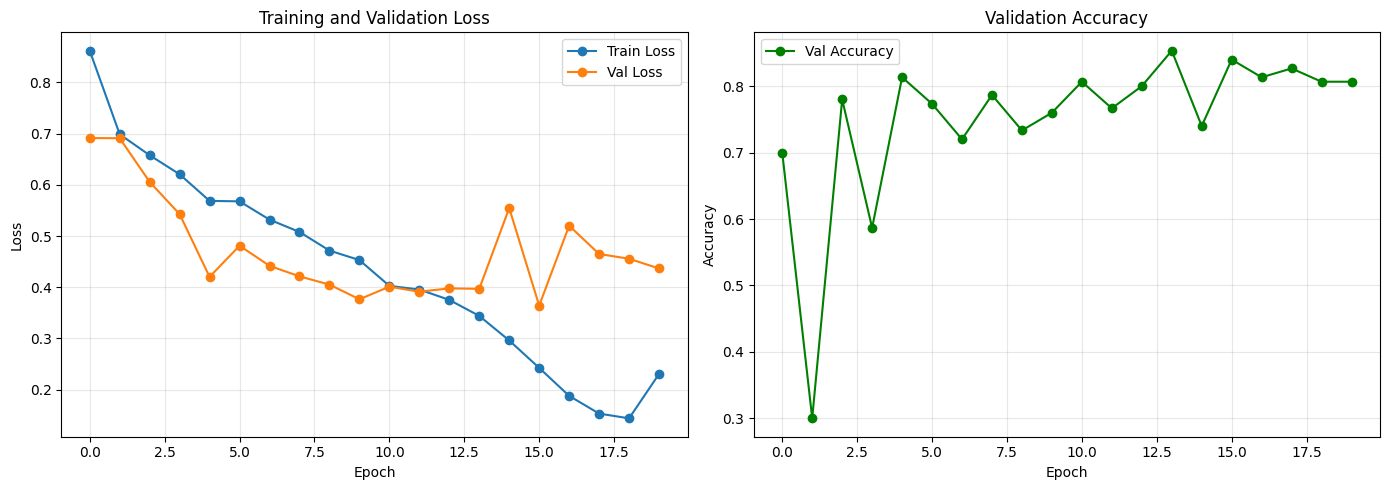


Training Summary:
Best Validation Accuracy: 0.8533 (Epoch 14)
Final Train Loss: 0.2305
Final Val Loss: 0.4366
Final Val Accuracy: 0.8067


In [22]:
# Plot training history
def plot_history(history):
    """Plot training history."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot losses
    axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
    axes[0].plot(history['val_loss'], label='Val Loss', marker='o')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Plot validation accuracy
    axes[1].plot(history['val_acc'], label='Val Accuracy', marker='o', color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nTraining Summary:")
    print(f"{'='*60}")
    print(f"Best Validation Accuracy: {max(history['val_acc']):.4f} (Epoch {history['val_acc'].index(max(history['val_acc']))+1})")
    print(f"Final Train Loss: {history['train_loss'][-1]:.4f}")
    print(f"Final Val Loss: {history['val_loss'][-1]:.4f}")
    print(f"Final Val Accuracy: {history['val_acc'][-1]:.4f}")
    print(f"{'='*60}")

plot_history(history)

In [23]:
# Evaluate on test set
test_acc = trainer.evaluate(test_loader)

Testing: 100%|██████████| 4/4 [00:02<00:00,  1.82it/s, acc=0.77] 


Test Set Evaluation
Total Examples: 209
Correct Predictions: 161
Test Accuracy: 0.7703 (77.03%)



## BatchNorm
BatchNorm, is a simple layer using two learned parameters to try to ensure that each minibatch that goes through the network has a mean centered around 0 with a variance of 1. 

The `BatchNorm` layers make sure that large models don't get out of hand.

## Transfer Learning with Pretrained Models

Here's how to use pretrained models (like ResNet, AlexNet) with your Trainer workflow.

**Two approaches:**
1. **Transfer Learning** (recommended) - Use pretrained ImageNet weights and fine-tune
2. **Train from Scratch** - Random initialization (what you've been doing)

In [24]:
import torchvision.models as models
import torch.nn as nn

# OPTION 1: Transfer Learning with ResNet18 (RECOMMENDED!)
# Load pretrained model with ImageNet weights
model_resnet = models.resnet18(weights='IMAGENET1K_V1')  # Use pretrained weights

# Replace the final layer for our 2-class problem
# ResNet's final layer is called 'fc' (fully connected)
num_features = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_features, config.num_classes)

# Move to device
model_resnet = model_resnet.to(config.device)

print("ResNet18 with Transfer Learning:")
print(f"Total parameters: {sum(p.numel() for p in model_resnet.parameters()):,}")
print(f"Final layer: {model_resnet.fc}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/petershmorhun/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 71.6MB/s]


ResNet18 with Transfer Learning:
Total parameters: 11,177,538
Final layer: Linear(in_features=512, out_features=2, bias=True)


In [25]:
# OPTION 2: AlexNet with Transfer Learning
model_alex = models.alexnet(weights='IMAGENET1K_V1')

# AlexNet's final layer is in model.classifier[6]
model_alex.classifier[6] = nn.Linear(4096, config.num_classes)

# Move to device
model_alex = model_alex.to(config.device)

print("AlexNet with Transfer Learning:")
print(f"Total parameters: {sum(p.numel() for p in model_alex.parameters()):,}")
print(f"Final layer: {model_alex.classifier[6]}")

AlexNet with Transfer Learning:
Total parameters: 57,012,034
Final layer: Linear(in_features=4096, out_features=2, bias=True)


In [26]:
# OPTION 3: Fine-tuning Strategy - Freeze early layers, only train classifier
# This is often BEST for small datasets!

model_resnet_frozen = models.resnet18(weights='IMAGENET1K_V1')

# Freeze all layers
for param in model_resnet_frozen.parameters():
    param.requires_grad = False

# Replace final layer (this layer WILL be trained)
num_features = model_resnet_frozen.fc.in_features
model_resnet_frozen.fc = nn.Linear(num_features, config.num_classes)

# Move to device
model_resnet_frozen = model_resnet_frozen.to(config.device)

print("ResNet18 with Frozen Features:")
print(f"Total parameters: {sum(p.numel() for p in model_resnet_frozen.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model_resnet_frozen.parameters() if p.requires_grad):,}")
print("Only training the final layer - FAST and prevents overfitting!")

ResNet18 with Frozen Features:
Total parameters: 11,177,538
Trainable parameters: 1,026
Only training the final layer - FAST and prevents overfitting!


In [30]:
# Now use any of these models with your Trainer!
# Example: Train ResNet with frozen features (recommended for your dataset size)

# Update config for transfer learning
config.learning_rate = 0.0001  # Lower LR for fine-tuning
config.epochs = 20
config.model_save_path = config.checkpoint_dir / 'resnet_frozen_best.pth'

# Create trainer with the pretrained model
trainer_resnet = Trainer(model_resnet_frozen, config)

print(f"\nReady to train ResNet18 with frozen features!")
print(f"Just run:")
print(f"  history = trainer_resnet.fit(train_loader, val_loader, epochs=config.epochs)")
print(f"\nExpected: ~80-85% accuracy, MUCH faster than training from scratch!")


Ready to train ResNet18 with frozen features!
Just run:
  history = trainer_resnet.fit(train_loader, val_loader, epochs=config.epochs)

Expected: ~80-85% accuracy, MUCH faster than training from scratch!


In [31]:
history = trainer_resnet.fit(train_loader, val_loader, epochs=config.epochs)


Starting training for 20 epochs...

Epoch 1/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s, loss=0.381, acc=0.78] 


✓ New best model saved! Val Acc: 0.7800
Train Loss: 0.5062 | Val Loss: 0.4653 | Val Acc: 0.7800 | LR: 0.000100

Epoch 2/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.31it/s, loss=0.368, acc=0.8]  


✓ New best model saved! Val Acc: 0.8000
Train Loss: 0.4920 | Val Loss: 0.4471 | Val Acc: 0.8000 | LR: 0.000100

Epoch 3/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.30it/s, loss=0.37, acc=0.807] 


✓ New best model saved! Val Acc: 0.8067
Train Loss: 0.4793 | Val Loss: 0.4378 | Val Acc: 0.8067 | LR: 0.000100

Epoch 4/20


Validating: 100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.348, acc=0.807]


Train Loss: 0.4610 | Val Loss: 0.4327 | Val Acc: 0.8067 | LR: 0.000100

Epoch 5/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.59it/s, loss=0.331, acc=0.807]


Train Loss: 0.4615 | Val Loss: 0.4295 | Val Acc: 0.8067 | LR: 0.000100

Epoch 6/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.53it/s, loss=0.367, acc=0.82] 


✓ New best model saved! Val Acc: 0.8200
Train Loss: 0.4530 | Val Loss: 0.4143 | Val Acc: 0.8200 | LR: 0.000100

Epoch 7/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.54it/s, loss=0.342, acc=0.827]


✓ New best model saved! Val Acc: 0.8267
Train Loss: 0.4350 | Val Loss: 0.4135 | Val Acc: 0.8267 | LR: 0.000100

Epoch 8/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s, loss=0.329, acc=0.827]


Train Loss: 0.4325 | Val Loss: 0.4099 | Val Acc: 0.8267 | LR: 0.000100

Epoch 9/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s, loss=0.331, acc=0.84] 


✓ New best model saved! Val Acc: 0.8400
Train Loss: 0.4183 | Val Loss: 0.4043 | Val Acc: 0.8400 | LR: 0.000100

Epoch 10/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.46it/s, loss=0.326, acc=0.853]


✓ New best model saved! Val Acc: 0.8533
Train Loss: 0.4131 | Val Loss: 0.3966 | Val Acc: 0.8533 | LR: 0.000100

Epoch 11/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s, loss=0.314, acc=0.847]


Train Loss: 0.4281 | Val Loss: 0.3928 | Val Acc: 0.8467 | LR: 0.000100

Epoch 12/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s, loss=0.336, acc=0.853]


Train Loss: 0.3961 | Val Loss: 0.3836 | Val Acc: 0.8533 | LR: 0.000100

Epoch 13/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s, loss=0.316, acc=0.833]


Train Loss: 0.3996 | Val Loss: 0.3840 | Val Acc: 0.8333 | LR: 0.000100

Epoch 14/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s, loss=0.297, acc=0.84] 


Train Loss: 0.3914 | Val Loss: 0.3835 | Val Acc: 0.8400 | LR: 0.000100

Epoch 15/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.47it/s, loss=0.302, acc=0.853]


Train Loss: 0.3952 | Val Loss: 0.3737 | Val Acc: 0.8533 | LR: 0.000100

Epoch 16/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.38it/s, loss=0.304, acc=0.847]


Train Loss: 0.3893 | Val Loss: 0.3756 | Val Acc: 0.8467 | LR: 0.000100

Epoch 17/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.50it/s, loss=0.298, acc=0.847]


Train Loss: 0.3977 | Val Loss: 0.3714 | Val Acc: 0.8467 | LR: 0.000100

Epoch 18/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.43it/s, loss=0.316, acc=0.853]


Train Loss: 0.3688 | Val Loss: 0.3721 | Val Acc: 0.8533 | LR: 0.000100

Epoch 19/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.45it/s, loss=0.316, acc=0.86] 


✓ New best model saved! Val Acc: 0.8600
Train Loss: 0.3725 | Val Loss: 0.3690 | Val Acc: 0.8600 | LR: 0.000100

Epoch 20/20


Validating: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s, loss=0.302, acc=0.86] 

Train Loss: 0.3628 | Val Loss: 0.3637 | Val Acc: 0.8600 | LR: 0.000100

Training complete! Best Val Acc: 0.8600


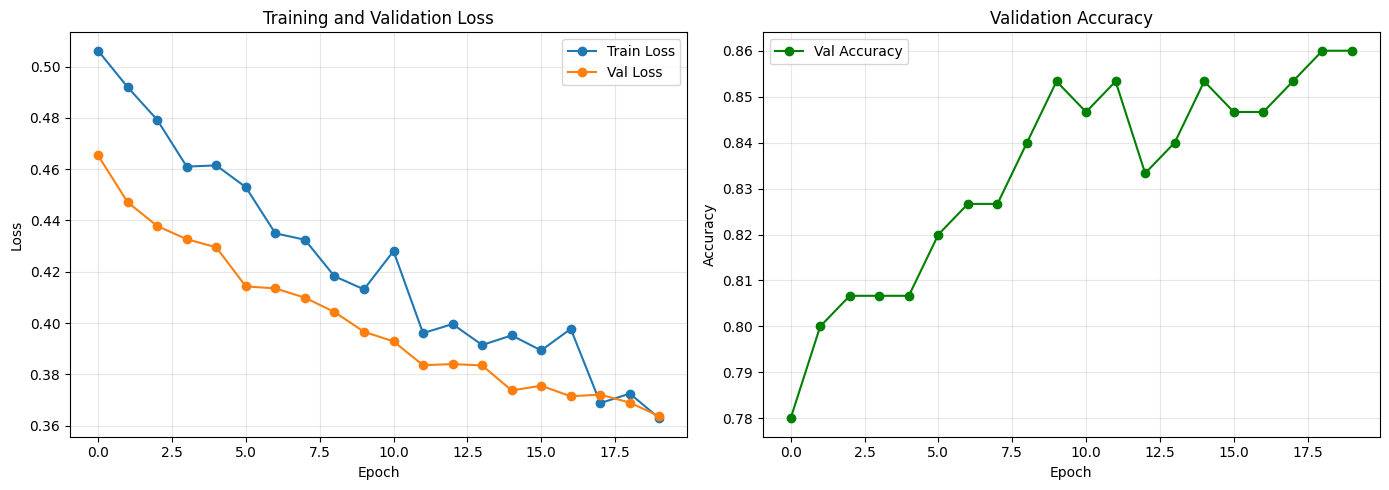


Training Summary:
Best Validation Accuracy: 0.8600 (Epoch 19)
Final Train Loss: 0.3628
Final Val Loss: 0.3637
Final Val Accuracy: 0.8600


In [32]:
plot_history(history)